In [0]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
batch_size = 512
num_classes = 10
epochs = 50
data_augmentation = False
num_predictions = 20

In [74]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
def experiment(x_train,y_train,x_test,y_test,filters1_size,filters2_size,kernel_size,padding):
  model = Sequential()
  model.add(Conv2D(filters1_size, kernel_size,padding=padding,
                   input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(filters1_size, kernel_size))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters2_size, kernel_size,padding=padding))
  model.add(Activation('relu'))
  model.add(Conv2D(filters2_size, kernel_size))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate RMSprop optimizer
  opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

  # Let's train the model using RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  
  history = None
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                shuffle=True)
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)
          # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

      # Fit the model on the batches generated by datagen.flow().
      history = model.fit_generator(datagen.flow(x_train, y_train,
                                       batch_size=batch_size),
                          epochs=epochs,
                           steps_per_epoch= 10,
                          validation_data=(x_test, y_test),
                          workers=4)
  
            # Score trained model.
  scores = model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
#   return history
  return (history, scores[0],scores[1])


In [0]:
plot_accuracy_loss(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values) + 1)
  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.legend()
  plt.show()
  

Using real-time data augmentation.
Epoch 1/100
10/10 [==============================] - 5s 497ms/step - loss: 2.2978 - acc: 0.1137 - val_loss: 2.2791 - val_acc: 0.1430
Epoch 2/100
10/10 [==============================] - 3s 266ms/step - loss: 2.2619 - acc: 0.1441 - val_loss: 2.2300 - val_acc: 0.2027
Epoch 3/100
10/10 [==============================] - 4s 381ms/step - loss: 2.2016 - acc: 0.1881 - val_loss: 2.1463 - val_acc: 0.2385
Epoch 4/100
10/10 [==============================] - 3s 295ms/step - loss: 2.1490 - acc: 0.2094 - val_loss: 2.1019 - val_acc: 0.2456
Epoch 5/100
10/10 [==============================] - 4s 374ms/step - loss: 2.1049 - acc: 0.2172 - val_loss: 2.0718 - val_acc: 0.2658
Epoch 6/100
10/10 [==============================] - 3s 307ms/step - loss: 2.0982 - acc: 0.2223 - val_loss: 2.0457 - val_acc: 0.2738
Epoch 7/100
10/10 [==============================] - 4s 368ms/step - loss: 2.0669 - acc: 0.2402 - val_loss: 2.0243 - val_acc: 0.2735
Epoch 8/100
10/10 [===============

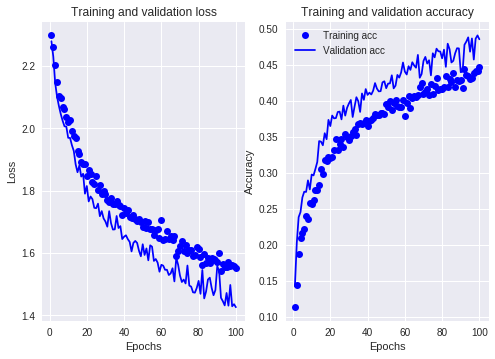

In [63]:
# using the image argument
history = experiment(x_train,y_train,x_test,y_test,32,64,(3,3),'same')
plot_accuracy_loss(history)

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 189us/step - loss: 2.1200 - acc: 0.2158 - val_loss: 1.9357 - val_acc: 0.3192
Epoch 2/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.8813 - acc: 0.3219 - val_loss: 1.8112 - val_acc: 0.3615
Epoch 3/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.7600 - acc: 0.3673 - val_loss: 1.6791 - val_acc: 0.4011
Epoch 4/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.6913 - acc: 0.3878 - val_loss: 1.6040 - val_acc: 0.4299
Epoch 5/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.6378 - acc: 0.4097 - val_loss: 1.5788 - val_acc: 0.4353
Epoch 6/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.5919 - acc: 0.4237 - val_loss: 1.4969 - val_acc: 0.4646
Epoch 7/20
50000/50000 [==============================] - 8s 158us/step - loss: 1.5536 - acc:

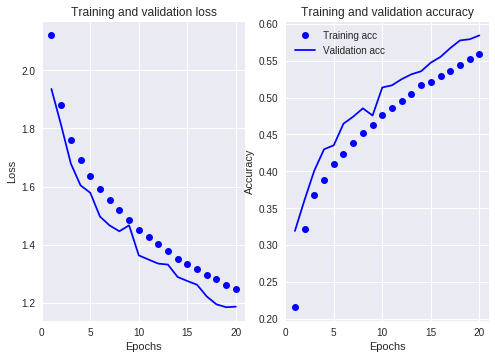

In [71]:
# Experiment test
exper_result = experiment(x_train,y_train,x_test,y_test,32,64,(3,3),'same')
plot_accuracy_loss(exper_result[0])

--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 182us/step - loss: 2.1641 - acc: 0.1896 - val_loss: 2.0097 - val_acc: 0.2636
Epoch 2/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.9421 - acc: 0.2887 - val_loss: 1.8089 - val_acc: 0.3641
Epoch 3/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.8085 - acc: 0.3464 - val_loss: 1.7279 - val_acc: 0.3885
Epoch 4/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.7327 - acc: 0.3740 - val_loss: 1.6317 - val_acc: 0.4147
Epoch 5/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.6666 - acc: 0.3967 - val_loss: 1.5778 - val_acc: 0.4311
Epoch 6/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.6196 - acc: 0.4104 - val_loss: 1.5290 - val_acc: 0.4517
Epoch 7

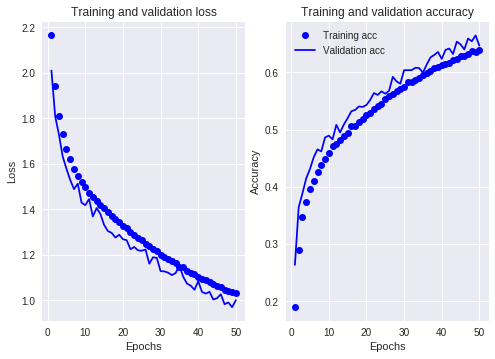

filters1: 32 filters2:64 kernel_size: (3, 3) stride_item: (2, 2) padding_item: valid activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 206us/step - loss: 2.0973 - acc: 0.2242 - val_loss: 1.9359 - val_acc: 0.3081
Epoch 2/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.8652 - acc: 0.3242 - val_loss: 1.7543 - val_acc: 0.3800
Epoch 3/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.7680 - acc: 0.3589 - val_loss: 1.6814 - val_acc: 0.3959
Epoch 4/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.6963 - acc: 0.3787 - val_loss: 1.6811 - val_acc: 0.3932
Epoch 5/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.6450 - ac

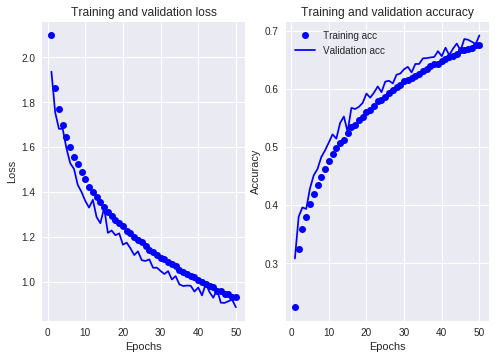

filters1: 32 filters2:64 kernel_size: (3, 3) stride_item: (2, 2) padding_item: same activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 189us/step - loss: 2.1798 - acc: 0.1751 - val_loss: 2.0724 - val_acc: 0.2329
Epoch 2/50
50000/50000 [==============================] - 7s 131us/step - loss: 2.0161 - acc: 0.2438 - val_loss: 1.9839 - val_acc: 0.2595
Epoch 3/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.9225 - acc: 0.2857 - val_loss: 1.8355 - val_acc: 0.3237
Epoch 4/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.8642 - acc: 0.3109 - val_loss: 1.8422 - val_acc: 0.3379
Epoch 5/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.8199 - acc:

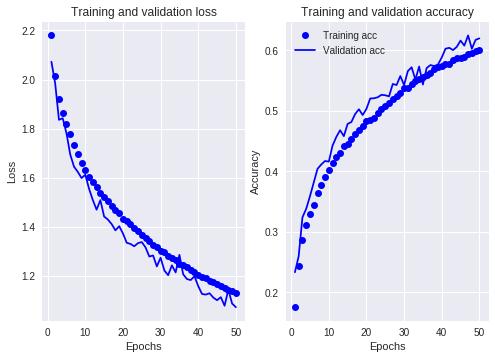

filters1: 32 filters2:64 kernel_size: (4, 4) stride_item: (2, 2) padding_item: valid activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 274us/step - loss: 2.0675 - acc: 0.2238 - val_loss: 1.8606 - val_acc: 0.3397
Epoch 2/50
50000/50000 [==============================] - 10s 208us/step - loss: 1.8436 - acc: 0.3240 - val_loss: 1.7450 - val_acc: 0.3702
Epoch 3/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.7605 - acc: 0.3597 - val_loss: 1.6625 - val_acc: 0.4017
Epoch 4/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.6986 - acc: 0.3798 - val_loss: 1.6171 - val_acc: 0.4082
Epoch 5/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.6474 

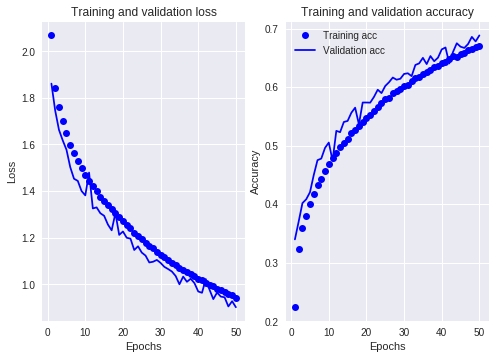

filters1: 32 filters2:64 kernel_size: (4, 4) stride_item: (2, 2) padding_item: same activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 241us/step - loss: 2.0613 - acc: 0.2370 - val_loss: 1.8654 - val_acc: 0.3304
Epoch 2/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.8233 - acc: 0.3403 - val_loss: 1.7134 - val_acc: 0.3870
Epoch 3/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.7344 - acc: 0.3723 - val_loss: 1.6610 - val_acc: 0.3971
Epoch 4/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.6724 - acc: 0.3944 - val_loss: 1.5882 - val_acc: 0.4351
Epoch 5/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.6230 - acc

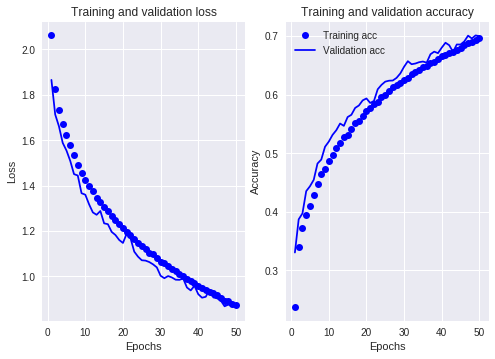

filters1: 32 filters2:128 kernel_size: (3, 3) stride_item: (2, 2) padding_item: valid activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 286us/step - loss: 2.1028 - acc: 0.2279 - val_loss: 1.8703 - val_acc: 0.3505
Epoch 2/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.8138 - acc: 0.3474 - val_loss: 1.7000 - val_acc: 0.4001
Epoch 3/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.6951 - acc: 0.3915 - val_loss: 1.5822 - val_acc: 0.4415
Epoch 4/50
50000/50000 [==============================] - 11s 217us/step - loss: 1.6132 - acc: 0.4196 - val_loss: 1.5324 - val_acc: 0.4538
Epoch 5/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.5526

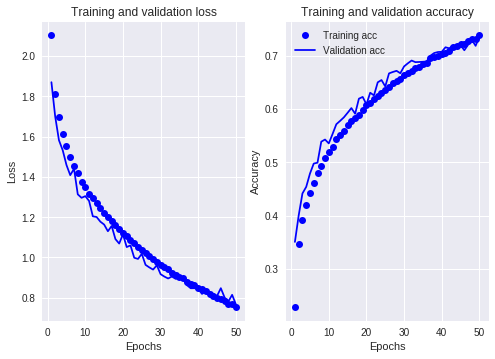

filters1: 32 filters2:128 kernel_size: (3, 3) stride_item: (2, 2) padding_item: same activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 241us/step - loss: 2.1090 - acc: 0.2085 - val_loss: 1.9107 - val_acc: 0.2996
Epoch 2/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.9150 - acc: 0.2943 - val_loss: 1.8286 - val_acc: 0.3406
Epoch 3/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.8296 - acc: 0.3283 - val_loss: 1.7417 - val_acc: 0.3709
Epoch 4/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.7698 - acc: 0.3489 - val_loss: 1.6560 - val_acc: 0.4066
Epoch 5/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.7147 - ac

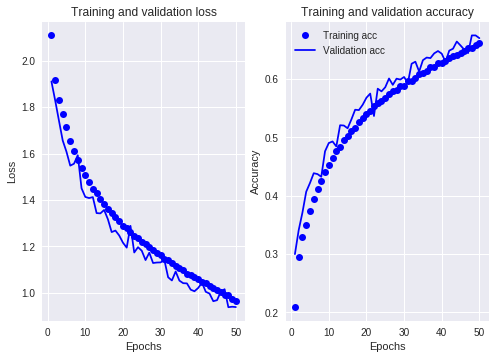

filters1: 32 filters2:128 kernel_size: (4, 4) stride_item: (2, 2) padding_item: valid activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 19s 371us/step - loss: 2.0459 - acc: 0.2532 - val_loss: 1.8356 - val_acc: 0.3505
Epoch 2/50
50000/50000 [==============================] - 15s 293us/step - loss: 1.8353 - acc: 0.3372 - val_loss: 1.8107 - val_acc: 0.3568
Epoch 3/50
50000/50000 [==============================] - 15s 293us/step - loss: 1.7435 - acc: 0.3735 - val_loss: 1.6443 - val_acc: 0.4135
Epoch 4/50
50000/50000 [==============================] - 15s 292us/step - loss: 1.6689 - acc: 0.3973 - val_loss: 1.5533 - val_acc: 0.4428
Epoch 5/50
50000/50000 [==============================] - 15s 292us/step - loss: 1.6042

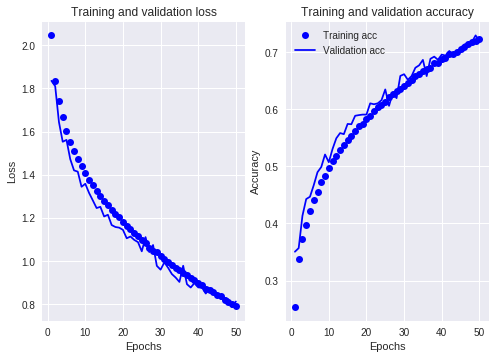

filters1: 32 filters2:128 kernel_size: (4, 4) stride_item: (2, 2) padding_item: same activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 287us/step - loss: 2.1061 - acc: 0.2148 - val_loss: 1.9042 - val_acc: 0.3242
Epoch 2/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.8689 - acc: 0.3167 - val_loss: 1.7741 - val_acc: 0.3636
Epoch 3/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.7713 - acc: 0.3561 - val_loss: 1.6660 - val_acc: 0.4025
Epoch 4/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.7029 - acc: 0.3779 - val_loss: 1.6044 - val_acc: 0.4220
Epoch 5/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.6429 

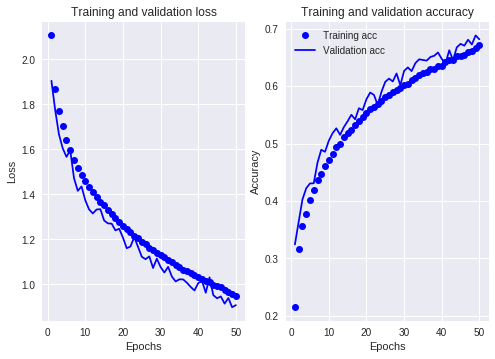

filters1: 64 filters2:64 kernel_size: (3, 3) stride_item: (2, 2) padding_item: valid activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 342us/step - loss: 2.0972 - acc: 0.2205 - val_loss: 1.9292 - val_acc: 0.3227
Epoch 2/50
50000/50000 [==============================] - 13s 251us/step - loss: 1.8499 - acc: 0.3314 - val_loss: 1.7273 - val_acc: 0.3945
Epoch 3/50
50000/50000 [==============================] - 13s 251us/step - loss: 1.7389 - acc: 0.3738 - val_loss: 1.6488 - val_acc: 0.4058
Epoch 4/50
50000/50000 [==============================] - 13s 252us/step - loss: 1.6714 - acc: 0.3955 - val_loss: 1.5735 - val_acc: 0.4360
Epoch 5/50
50000/50000 [==============================] - 13s 251us/step - loss: 1.6147 

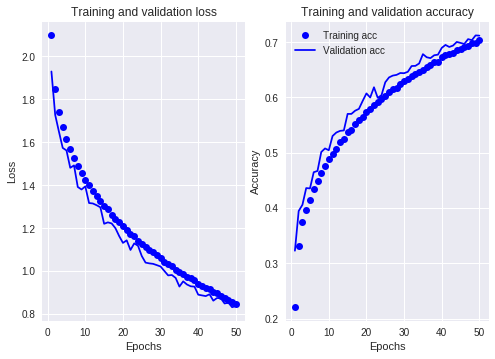

filters1: 64 filters2:64 kernel_size: (3, 3) stride_item: (2, 2) padding_item: same activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 285us/step - loss: 2.1501 - acc: 0.1886 - val_loss: 1.9950 - val_acc: 0.2633
Epoch 2/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.9716 - acc: 0.2684 - val_loss: 1.8540 - val_acc: 0.3298
Epoch 3/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.8722 - acc: 0.3074 - val_loss: 1.7874 - val_acc: 0.3530
Epoch 4/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.8050 - acc: 0.3348 - val_loss: 1.7185 - val_acc: 0.3781
Epoch 5/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.7469 -

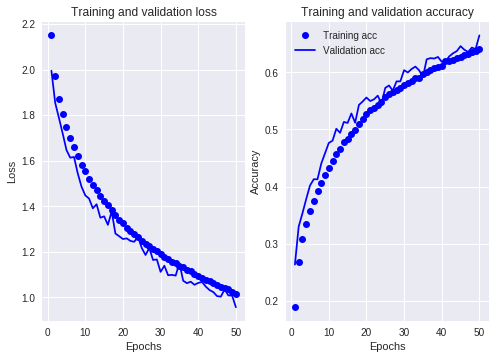

filters1: 64 filters2:64 kernel_size: (4, 4) stride_item: (2, 2) padding_item: valid activation_item: relu
--------------------------------Experiment End-------------------------------------
--------------------------------Experiment Start-------------------------------------
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 21s 417us/step - loss: 2.0728 - acc: 0.2325 - val_loss: 1.8430 - val_acc: 0.3403
Epoch 2/50
50000/50000 [==============================] - 16s 318us/step - loss: 1.8505 - acc: 0.3271 - val_loss: 1.7268 - val_acc: 0.3759
Epoch 3/50
50000/50000 [==============================] - 16s 318us/step - loss: 1.7692 - acc: 0.3577 - val_loss: 1.7754 - val_acc: 0.3652
Epoch 4/50
50000/50000 [==============================] - 16s 317us/step - loss: 1.6849 - acc: 0.3876 - val_loss: 1.5746 - val_acc: 0.4261
Epoch 5/50
50000/50000 [==============================] - 16s 318us/step - loss: 1.6299 

In [0]:
filters1_size = [32,64]
filters2_size = [64,128]
kernel_size = [(3,3),(4,4)]
strides = [(2,2),(3,3)]
padding = ['valid','same']
activation = ['relu']
result_dict = dict()
tests_accuracy = list()
tests_loss = list()
record = list()

for filters1_item in filters1_size :
    for filters2_item in filters2_size:
      for  kernel_item in kernel_size:
        for padding_item in padding:
              for activation_item in activation:
                print("--------------------------------Experiment Start-------------------------------------")
                exper_result = experiment(x_train,y_train,x_test,y_test,filters1_item,filters2_item,kernel_item,padding_item)
                plot_accuracy_loss(exper_result[0])
                exper_parameters = 'filters1: '+ str(filters1_item) + ' filters2:'+ str(filters2_item) + ' kernel_size: ' +str(kernel_item) + ' stride_item: '+str(stride_item) + ' padding_item: ' + str(padding_item) + ' activation_item: ' + str(activation_item)
                print(exper_parameters)
                tests_loss.append(exper_result[1])
                tests_accuracy.append(exper_result[2])
                colum_item = [filters1_item,filters2_item,kernel_item,padding_item,activation_item]
                record.append(colum_item)
                print("--------------------------------Experiment End-------------------------------------")
#         for stride_item in strides:

In [0]:
df = DataFrame(record,columns = ['filters1_num','filters2',' kernel_size: ','stride_num','padding_num','activation'])

In [0]:
  numbers = range(1, len(tests_accuracy) + 1)  
  plt.subplot(1,2,1)
  plt.plot(numbers, tests_loss, 'bo', label='Training loss')
  plt.title(''Test loss of All Experiments')
  plt.xlabel('No.')
  plt.ylabel('Loss')

  plt.subplot(1,2,2)
  plt.plot(numbers, tests_accuracy, 'bo', label='Test acc')
  plt.title('Test accuracy of All Experiments')
  plt.xlabel('No.')
  plt.ylabel('Accuracy')

  plt.legend()
  plt.show()